In [1]:
import datetime
import os
import pandas as pd

from data import load_raw_data, clean_raw_data, sample_tickers_dates, split_train_test_panel, build_features

In [2]:
# Configuration parameters
sample_tickers = ['AAPL', 'AMZN']
target = 'returns'
forecast_steps = 5

In [3]:
rootpath = os.path.dirname(os.path.dirname(os.getcwd()))
datapath = os.path.join(rootpath, 'data')
datasetname='world-stock-prices-daily-updating'
df_raw = load_raw_data(
    datapath = datapath,
    user='nelgiriyewithana',
    datasetname=datasetname)
df_clean = clean_raw_data(df_raw)


rootpath: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data
Raw data already found in location /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data
reading raw data from: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data/world-stock-prices-daily-updating/World-Stock-Prices-Dataset.csv


In [4]:
df = sample_tickers_dates(
    df_clean,
    tickers=sample_tickers,
    startdate=datetime.datetime.now() - datetime.timedelta(days=365*5+1),
    clean_sample_fpath_full=None
    # clean_sample_fpath_full=os.path.join(datapath, f'{datasetname}_clean_sample.csv')
    )

Sampling tickers: ['AAPL', 'AMZN']
Sampling from start date: 2020-07-20 21:50:53.526513


In [5]:
# df_train, df_test = split_train_test(df, train_ratio=0.8)
df_train, df_test = split_train_test_panel(df, train_ratio=0.8)

In [6]:
df_train_feats, features2scale = build_features(df_train, lags=3)
df_test_feats, features2scale = build_features(df_test, lags=3)

In [7]:
def make_multistep_target(y, steps):
    y_multi = pd.concat(
        {f'y_step_{i + 1}': y.shift(-i)
         for i in range(steps)},
        axis=1
        )
    y_multi.dropna(inplace=True)
    return y_multi

def get_X_y_multistep(df_all, steps=5, target='Returns'):
    y_list = []
    X_list = []
    # loop over tickers to create multistep targets
    for ticker, grp in df_all.groupby('Ticker'):
        df = grp.sort_values('Date').copy()
        y = df[target]
        y_multi = make_multistep_target(y, steps=steps).dropna()
        X = df.drop(columns=['Ticker', target])
        # Shifting has created indexes that don't match. Only keep times for
        # which we have both targets and features.
        y_multi, X = y_multi.align(X, join='inner', axis=0)
        # check whether anything left from X and y_multi after droppping Nas
        if y_multi.shape[0] == 0 or X.shape[0] == 0:
            print(f"For ticker: {ticker}, no data left after dropping NaNs.")
        else:
            y_list.append(y_multi)
            X_list.append(X)
    if len(y_list) == 0 or len(X_list) == 0:
        raise ValueError("No data left after processing. Check your input data and parameters.")
    else:
        y_multi_all = pd.concat(y_list)
        X_all = pd.concat(X_list)
        print(f'X shape: {X_all.shape}, y_multi shape: {y_multi_all.shape}')
        X_all.set_index('Date', inplace=True)
        y_multi_all.index = X_all.index
        return X_all, y_multi_all

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

def evaluate_multistep(y_train, y_hat_train, y_test, y_hat_test, df, target):
    train_rmse = root_mean_squared_error(y_train, y_hat_train)
    test_rmse = root_mean_squared_error(y_test, y_hat_test)
    print((f"Train RMSE: {train_rmse:.5f}\n" f"Test RMSE: {test_rmse:.5f}"))

    plt.rc("figure", autolayout=True, figsize=(12, 6))
    plt.rc(
        "axes",
        labelweight="bold",
        labelsize="large",
        titleweight="bold",
        titlesize=16,
        titlepad=10,
    )

    plot_params = dict(
        color="0.75",
        style=".-",
        markeredgecolor="0.25",
        markerfacecolor="0.25",
    )
    palette = dict(palette='husl', n_colors=64)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
    ax1 = df[target][y_hat_train.index].plot(**plot_params, ax=ax1)
    ax1 = plot_multistep(y_hat_train, ax=ax1, palette_kwargs=palette)
    _ = ax1.legend([f'{target} (train)', 'Forecast'])
    ax2 = df[target][y_hat_test.index].plot(**plot_params, ax=ax2)
    ax2 = plot_multistep(y_hat_test, ax=ax2, palette_kwargs=palette)
    _ = ax2.legend([f'{target} (test)', 'Forecast'])

In [9]:
X_train, y_train = get_X_y_multistep(df_train_feats, steps=forecast_steps, target=target)
X_test, y_test = get_X_y_multistep(df_test_feats, steps=forecast_steps, target=target)

X shape: (1876, 31), y_multi shape: (1876, 5)
X shape: (390, 31), y_multi shape: (390, 5)


In [10]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

Preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features2scale),
    ],
    remainder='passthrough'
)
model = LinearRegression()
pipeline = Pipeline(
    steps=[
        ('preprocessor', Preprocessor),
        ('model', model)
        ]
        )
pipeline.fit(X_train, y_train)
y_train_hat = pipeline.predict(X_train)
y_test_hat = pipeline.predict(X_test)

Train RMSE: 5.44161
Test RMSE: 13.23785


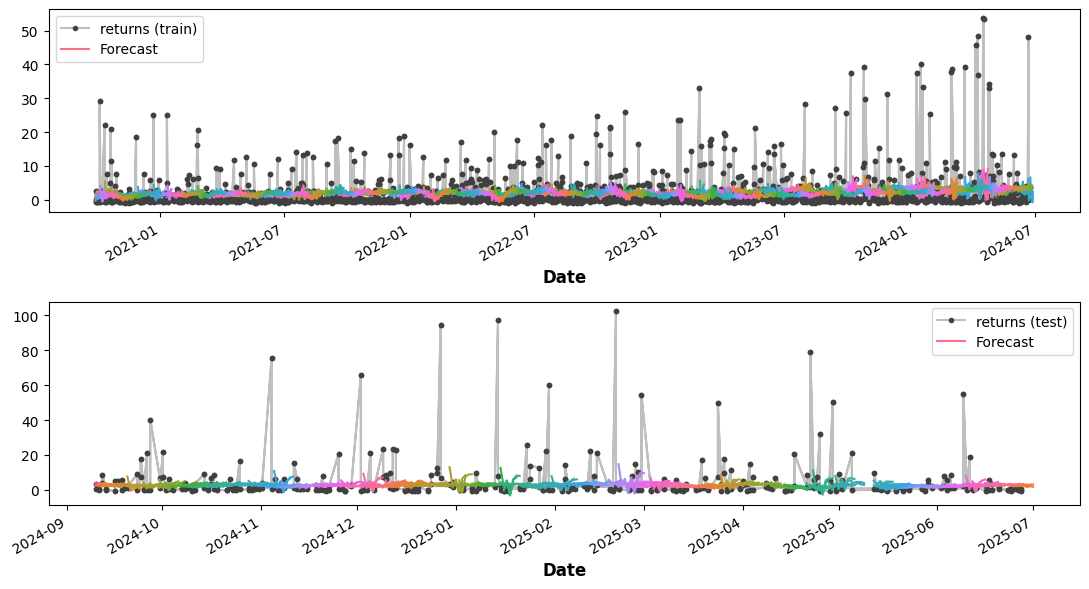

In [11]:
df_indexed = df.set_index('Date')
evaluate_multistep(
    y_train,
    pd.DataFrame(y_train_hat, index=y_train.index, columns=y_train.columns),
    y_test,
    pd.DataFrame(y_test_hat, index=y_test.index, columns=y_test.columns),
    df_indexed,
    target)